# Experiment 1: Parameter Estimation with Exact Data

This experiment is a recreation of the Mpox synthetic case found in the paper. We were unable to find the synthetic time series data $(s, e, i, r, d)(t)$ from the cited source, so we instead implemented a fractional ODE solver to generate data consistent with the provided epidemiological parameters. Ideally, the model should easily recover the epidemiological parameters.

## Import Statements

In [1]:
from caputo import caputo_euler
from EpiPINN import EpiPINN, train_stage1, train_stage2
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os

## Generate Data

Data is generated by solving the following fractional-order ODE using the Caputo-Euler method.

$
\begin{align*}
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[s] &= -\beta \frac{si}{1 - d} \\
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[e] &= \beta \frac{si}{1 - d} - \sigma e \\
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[i] &= \sigma e - (\gamma + \mu) i \\
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[r] &= \gamma i \\
_{0}^{\mathrm{C}}\mathrm{D}_{t}^{\alpha}[d] &= \mu i
\end{align*}
$

In [2]:
# Data generation
alpha_true = 0.95 # Derivative fraction used for data
beta_true = 0.25 # Infection rate used for model
sigma_true = 0.13 # Incubation rate used for model
gamma_true = 0.052 # Recovery rate used for model
mu_true = 0.005 # Death rate used for model
y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[2]) / (1 - y[4]),
    beta_true * (y[0] * y[2]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys, dtype=torch.float32)

## Build and Train Model

In [3]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.96 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.26 # Infection rate guess used for model
sigma_guess = 0.14 # Incubation rate guess used for model
gamma_guess = 0.053 # Recovery rate guess used for model
mu_guess = 0.006 # Death rate used guess for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1) # Where to enforce the FDE
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (ts_colloc[-1] - ts_colloc[0])[0].item() / len(ts_colloc)
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model1 = EpiPINN(hidden_size, depth, initial_params)

In [4]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-5),
    epochs=5000,
    patience=500,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/5000], Loss: 0.002503, Patience: 0
Epoch [200/5000], Loss: 0.001287, Patience: 0
Epoch [300/5000], Loss: 0.000910, Patience: 0
Epoch [400/5000], Loss: 0.000533, Patience: 0
Epoch [500/5000], Loss: 0.000178, Patience: 0
Epoch [600/5000], Loss: 0.000089, Patience: 0
Epoch [700/5000], Loss: 0.000067, Patience: 2
Epoch [800/5000], Loss: 0.000062, Patience: 2
Epoch [900/5000], Loss: 0.000049, Patience: 7
Epoch [1000/5000], Loss: 0.000045, Patience: 3
Epoch [1100/5000], Loss: 0.000041, Patience: 0
Epoch [1200/5000], Loss: 0.000045, Patience: 19
Epoch [1300/5000], Loss: 0.000044, Patience: 21
Epoch [1400/5000], Loss: 0.000037, Patience: 4
Epoch [1500/5000], Loss: 0.000034, Patience: 7
Epoch [1600/5000], Loss: 0.000040, Patience: 16
Epoch [1700/5000], Loss: 0.000032, Patience: 2
Epoch [1800/5000], Loss: 0.000030, Patience: 0
Epoch [1900/5000], Loss: 0.000076, Patience: 21
Epoch [2000/5000], Loss: 0.000030, Patience: 11
Epoch [2100/5000], Loss: 0.000034, Patience: 38
Epoch [2200/5000

### Stage 1 Training Results

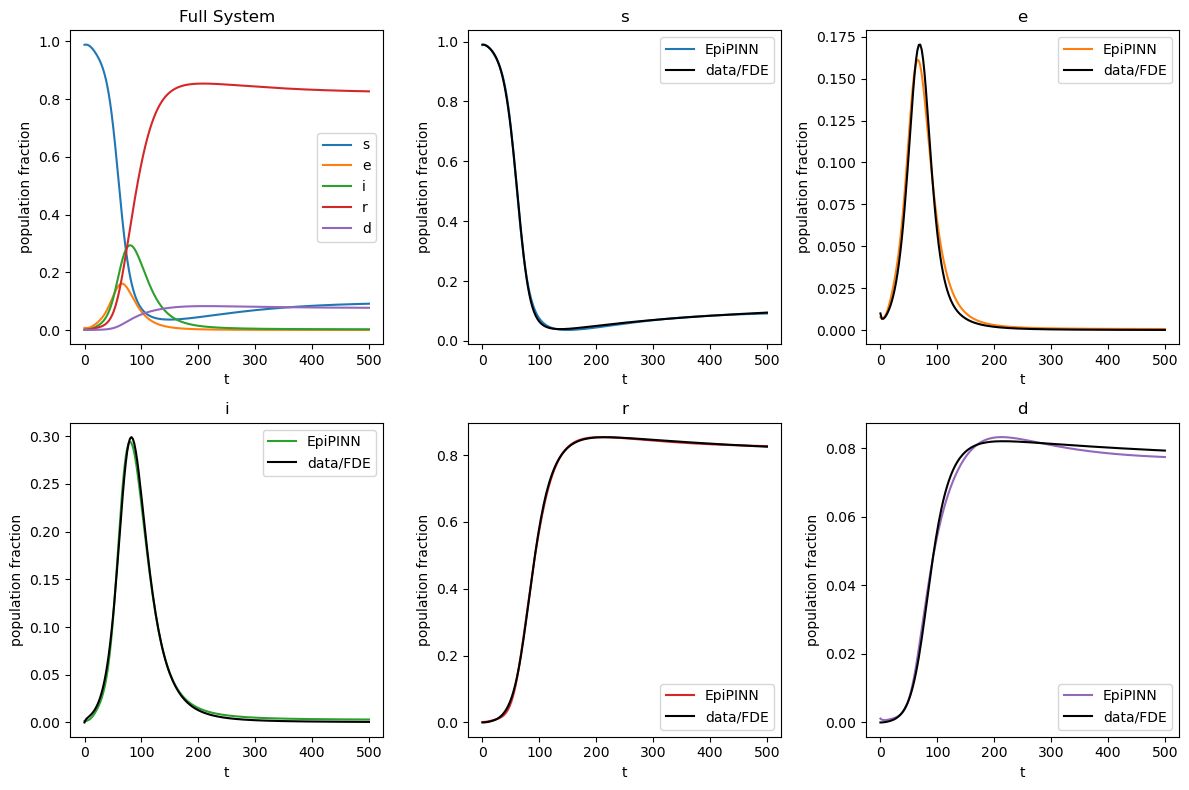

In [5]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].set_xlabel('t')
    axs[i // 3, i % 3].set_ylabel('population fraction')
    axs[i // 3, i % 3].legend()

fig.tight_layout()
fig.savefig('doc/images/experiment1_stage1.png')

In [6]:
# Start timing
start2 = time.time()

# Stage 2: weights and epidemiological parameters, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-4, weight_decay=1e-5),
    epochs=5000,
    patience=500,
    weight_ic_phys=1e6,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/5000], Loss: 0.636652, Patience: 0
Epoch [200/5000], Loss: 0.272496, Patience: 0
Epoch [300/5000], Loss: 0.143427, Patience: 0
Epoch [400/5000], Loss: 0.091758, Patience: 0
Epoch [500/5000], Loss: 0.067268, Patience: 0
Epoch [600/5000], Loss: 0.053522, Patience: 0
Epoch [700/5000], Loss: 0.044781, Patience: 0
Epoch [800/5000], Loss: 0.038578, Patience: 0
Epoch [900/5000], Loss: 0.033970, Patience: 0
Epoch [1000/5000], Loss: 0.030690, Patience: 1
Epoch [1100/5000], Loss: 0.027814, Patience: 0
Epoch [1200/5000], Loss: 0.025659, Patience: 0
Epoch [1300/5000], Loss: 0.023918, Patience: 0
Epoch [1400/5000], Loss: 0.022520, Patience: 0
Epoch [1500/5000], Loss: 0.021352, Patience: 1
Epoch [1600/5000], Loss: 0.020341, Patience: 3
Epoch [1700/5000], Loss: 0.019388, Patience: 0
Epoch [1800/5000], Loss: 0.018611, Patience: 1
Epoch [1900/5000], Loss: 0.017929, Patience: 3
Epoch [2000/5000], Loss: 0.017343, Patience: 5
Epoch [2100/5000], Loss: 0.016796, Patience: 0
Epoch [2200/5000], Los

In [7]:
# Save model
torch.save(model1.state_dict(), 'experiment1.pth')

### Stage 2 Training Results

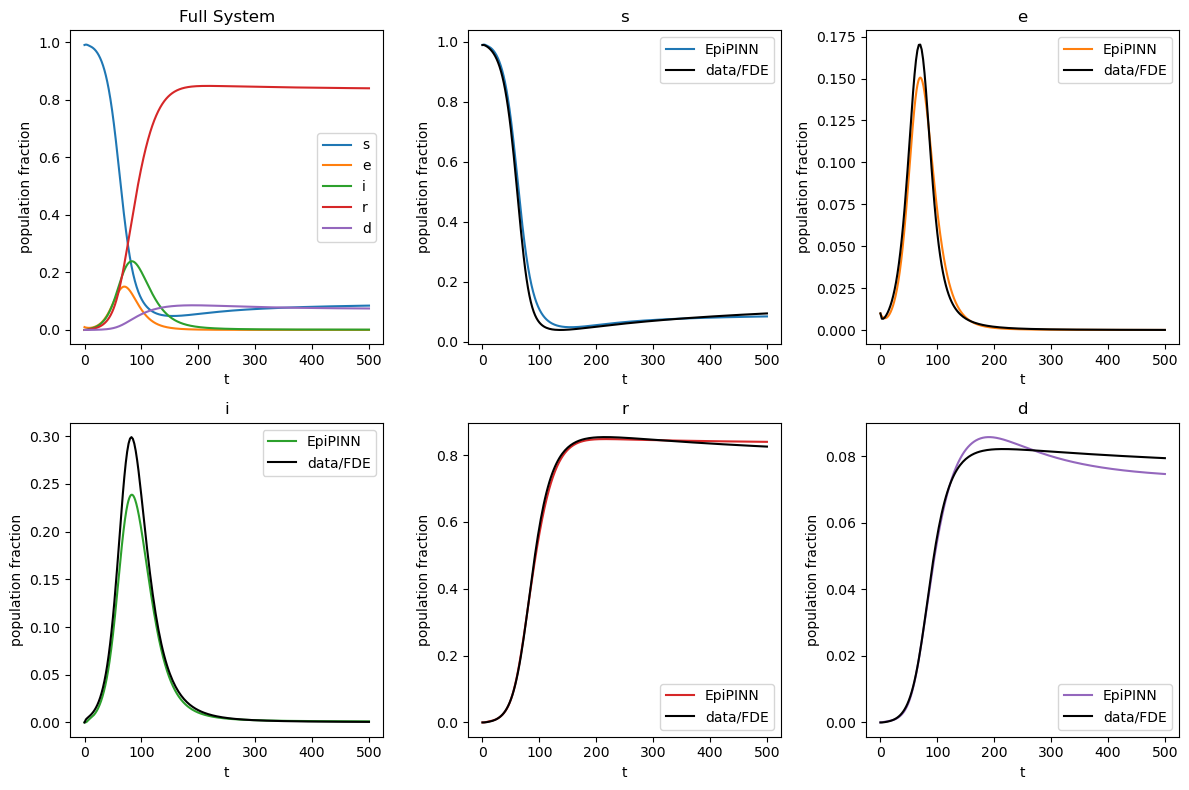

In [8]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].set_xlabel('t')
    axs[i // 3, i % 3].set_ylabel('population fraction')
    axs[i // 3, i % 3].legend()

fig.tight_layout()
fig.savefig('doc/images/experiment1_stage2.png')

## Loss and Parameter Estimation Analysis

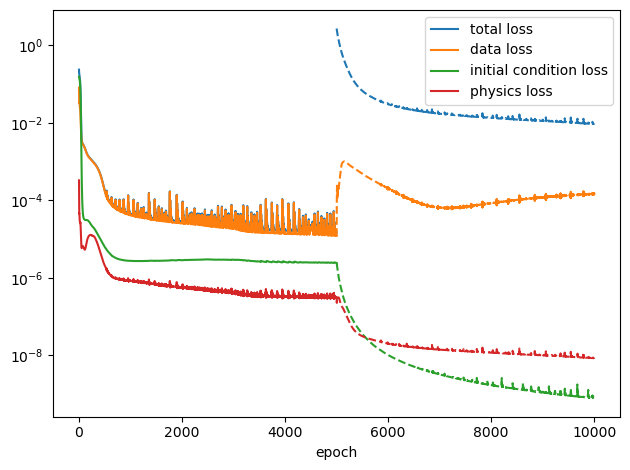

In [9]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

fig.tight_layout()
fig.savefig('doc/images/experiment1_losses.png')

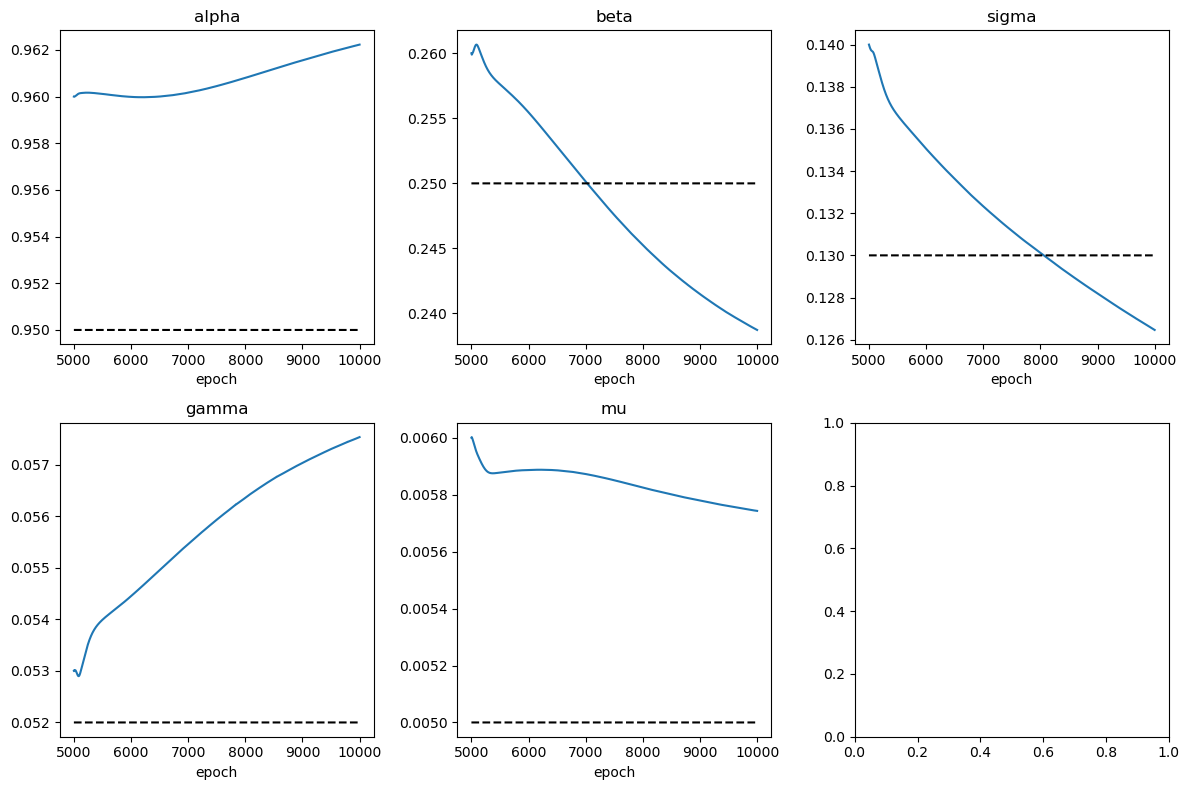

In [10]:
# Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')
axs[0, 0].set_xlabel('epoch')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')
axs[0, 1].set_xlabel('epoch')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')
axs[0, 2].set_xlabel('epoch')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')
axs[1, 0].set_xlabel('epoch')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')
axs[1, 1].set_xlabel('epoch')

fig.tight_layout()
fig.savefig('doc/images/experiment1_parameters.png')